In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,make_scorer


In [2]:
data = pd.read_csv("./Dataset/Fraud.csv")

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
print("Missing Values:")
data.isnull().sum()

Missing Values:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
duplicates= data.duplicated().sum()
print("\nDuplicate Entries:", duplicates)


Duplicate Entries: 0


In [7]:
data=pd.get_dummies(data, columns=['type'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  type_CASH_IN    uint8  
 11  type_CASH_OUT   uint8  
 12  type_DEBIT      uint8  
 13  type_PAYMENT    uint8  
 14  type_TRANSFER   uint8  
dtypes: float64(5), int64(3), object(2), uint8(5)
memory usage: 515.8+ MB


In [9]:
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


# **Encoding Categorical Variables**

In [10]:
en = LabelEncoder()
allCcols = ['nameOrig', 'nameDest']

for col in allCcols:
    data[col] = en.fit_transform(data[col])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   nameOrig        int64  
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        int64  
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  type_CASH_IN    uint8  
 11  type_CASH_OUT   uint8  
 12  type_DEBIT      uint8  
 13  type_PAYMENT    uint8  
 14  type_TRANSFER   uint8  
dtypes: float64(5), int64(5), uint8(5)
memory usage: 515.8 MB


# **Feature engineering**

In [12]:
transaction_frequency = data.groupby('nameOrig')['step'].transform('count')
data['transaction_frequency'] = transaction_frequency

In [13]:
average_transaction_amount = data.groupby(
    'nameOrig')['amount'].transform('mean')
data['average_transaction_amount'] = average_transaction_amount


In [14]:
# Extract time-related features
data['hour_of_day'] = data['step'] % 24
data['day_of_week'] = (data['step'] // 24) % 7
data['month_of_year'] = (data['step'] // (24 * 30)) % 12


In [15]:
#data['time_since_last_transaction'] = data.groupby('nameOrig')['step'].diff()

In [16]:
transaction_amount_deviation = data['amount'] - average_transaction_amount
data['transaction_amount_deviation'] = transaction_amount_deviation


In [17]:
# destination_account_frequency = data.groupby(
#     'nameDest')['step'].transform('count')
# data['destination_account_frequency'] = destination_account_frequency


In [18]:
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,transaction_frequency,average_transaction_amount,hour_of_day,day_of_week,month_of_year,transaction_amount_deviation
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,...,0,0,1,0,1,9839.64,1,0,0,0.0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,...,0,0,1,0,1,1864.28,1,0,0,0.0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,...,0,0,0,1,1,181.00,1,0,0,0.0
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,...,1,0,0,0,1,181.00,1,0,0,0.0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,...,0,0,1,0,1,11668.14,1,0,0,0.0


 # **Scaling Numerical Features**

In [19]:
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


In [20]:
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,transaction_frequency,average_transaction_amount,hour_of_day,day_of_week,month_of_year,transaction_amount_deviation
0,1,-0.281560,757869,-0.229810,-0.237622,1662094,-0.323814,-0.333411,0,0,...,0,0,1,0,1,9839.64,1,0,0,0.0
1,1,-0.294767,2188998,-0.281359,-0.285812,1733924,-0.323814,-0.333411,0,0,...,0,0,1,0,1,1864.28,1,0,0,0.0
2,1,-0.297555,1002156,-0.288654,-0.292442,439685,-0.323814,-0.333411,1,0,...,0,0,0,1,1,181.00,1,0,0,0.0
3,1,-0.297555,5828262,-0.288654,-0.292442,391696,-0.317582,-0.333411,1,0,...,1,0,0,0,1,181.00,1,0,0,0.0
4,1,-0.278532,3445981,-0.274329,-0.282221,828919,-0.323814,-0.333411,0,0,...,0,0,1,0,1,11668.14,1,0,0,0.0


# **Correlation analysis**

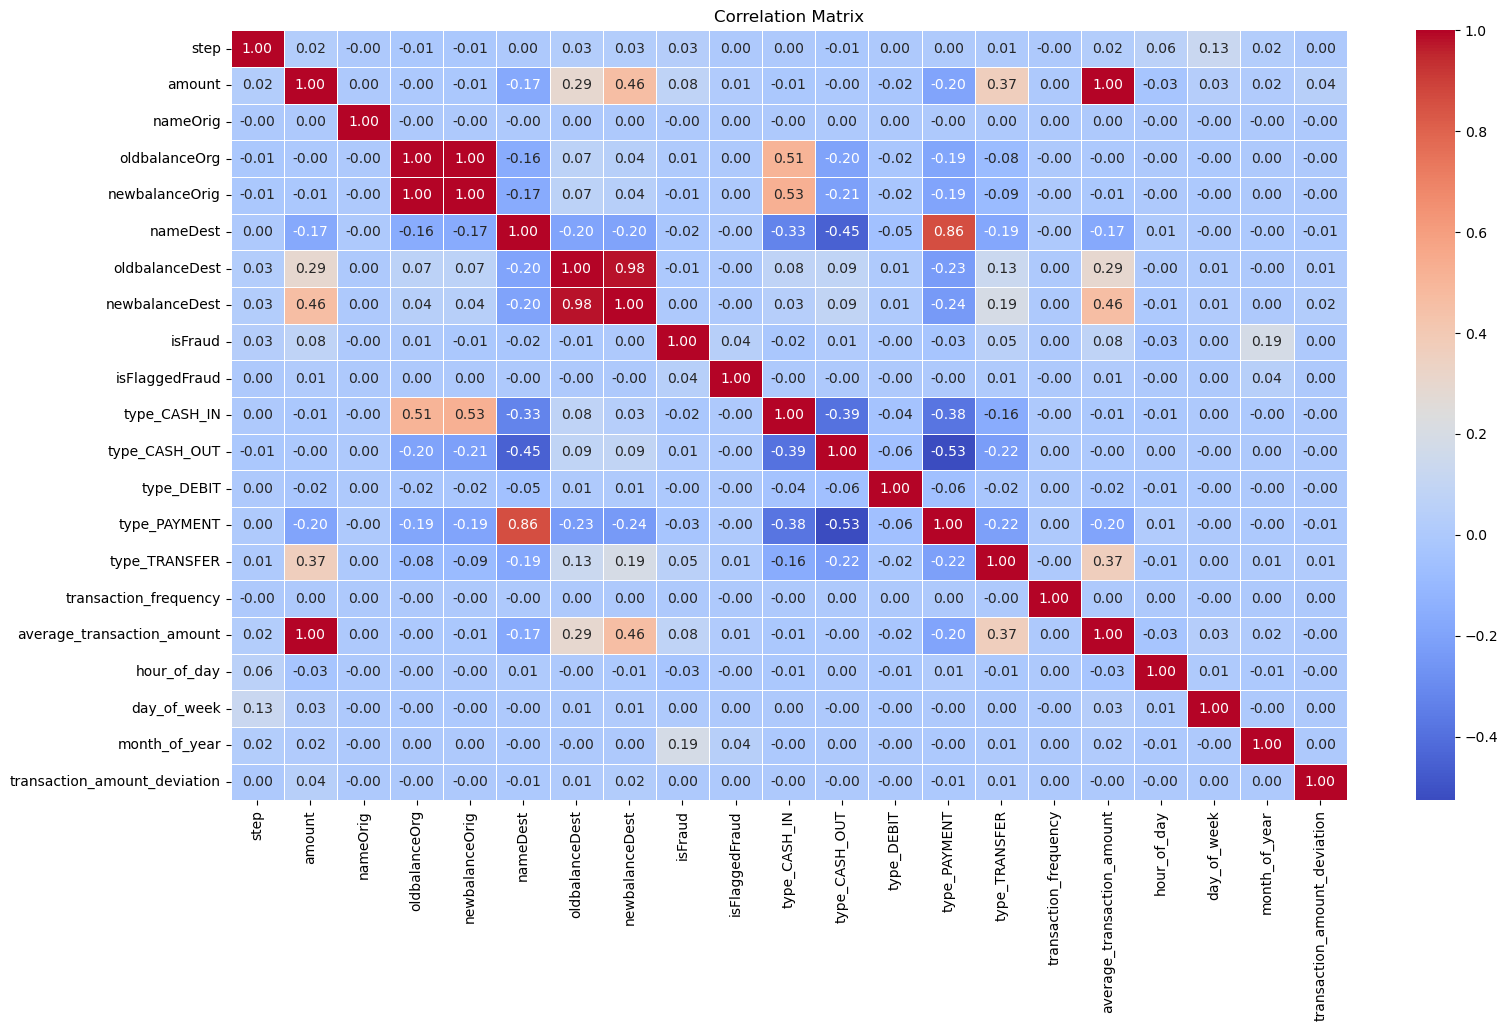

In [68]:
numeric_columns = data.select_dtypes(include=['float64', 'int64','uint8'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

1. *amount* and *average_transaction_amount*: These two variables have a strong positive correlation of 0.999006, which means that they are highly correlated. As the transaction amount increases, the average transaction amount also tends to increase.

2. *oldbalanceOrg* and *newbalanceOrig*: These variables have a strong positive correlation of 0.998803, indicating that they are closely related. When the old balance in the originating account increases, the new balance in the originating account also tends to increase.

3. *oldbalanceDest* and *newbalanceDest*: These variables show a strong positive correlation of 0.976569, suggesting a close relationship. As the old balance in the destination account increases, the new balance in the destination account also tends to increase.

4. *isFraud* and *month_of_year*: These variables have a positive correlation of 0.185184, indicating a weak positive relationship. It suggests that there might be some association between the occurrence of fraud and the month of the year.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   step                          int64  
 1   amount                        float64
 2   nameOrig                      int64  
 3   oldbalanceOrg                 float64
 4   newbalanceOrig                float64
 5   nameDest                      int64  
 6   oldbalanceDest                float64
 7   newbalanceDest                float64
 8   isFraud                       int64  
 9   isFlaggedFraud                int64  
 10  type_CASH_IN                  uint8  
 11  type_CASH_OUT                 uint8  
 12  type_DEBIT                    uint8  
 13  type_PAYMENT                  uint8  
 14  type_TRANSFER                 uint8  
 15  transaction_frequency         int64  
 16  average_transaction_amount    float64
 17  hour_of_day                   int64  
 18  day_of_week           

In [22]:
data.isna().sum()

step                            0
amount                          0
nameOrig                        0
oldbalanceOrg                   0
newbalanceOrig                  0
nameDest                        0
oldbalanceDest                  0
newbalanceDest                  0
isFraud                         0
isFlaggedFraud                  0
type_CASH_IN                    0
type_CASH_OUT                   0
type_DEBIT                      0
type_PAYMENT                    0
type_TRANSFER                   0
transaction_frequency           0
average_transaction_amount      0
hour_of_day                     0
day_of_week                     0
month_of_year                   0
transaction_amount_deviation    0
dtype: int64

In [23]:
#data_copy=data.copy()

In [24]:
data['isFraud'].unique()

array([0, 1])

In [25]:
X = data.drop('isFraud', axis=1)
y = data['isFraud']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [27]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (5090096, 20) (5090096,)
Testing set shape: (1272524, 20) (1272524,)


#  **XGBoost**

In [30]:
xgb_model = xgb.XGBClassifier()


In [39]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
y_pred = xgb_model.predict(X_test)

In [41]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [42]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.999838902841911
Precision: 0.9764309764309764
Recall: 0.8950617283950617
F1 Score: 0.9339774557165861
ROC AUC Score: 0.9475170944714146


# **Performance explanation**

1. Accuracy: The accuracy of the model is 0.9998, which means it correctly predicts 99.98% of the transactions in the dataset. This high accuracy indicates that the model is able to classify the majority of transactions correctly.

2. Precision: The precision of the model is 0.9764, which means that out of all the transactions predicted as fraudulent, 97.64% of them are actually fraudulent. In other words, the model has a low false positive rate, which is important in detecting fraudulent transactions accurately.

3. Recall: The recall of the model is 0.8951, indicating that it is able to identify 89.51% of the actual fraudulent transactions in the dataset. This measure is important to capture the true positives and avoid false negatives.

4. F1 Score: The F1 score is a balanced measure of precision and recall, and it is 0.9339 in this case. This score takes into account both false positives and false negatives and provides an overall evaluation of the model's performance.

5. ROC AUC Score: The ROC AUC score is 0.9475, which is a measure of the model's ability to discriminate between positive and negative classes. A higher ROC AUC score indicates a better model performance in distinguishing fraudulent transactions from non-fraudulent ones.

**Overall, the XGBoost model shows excellent performance in identifying fraudulent transactions, with high accuracy, precision, recall, F1 score, and ROC AUC score.**

# **Random Forest Classifier**

In [48]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [49]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
rf_y_pred = rf_model.predict(X_test)

In [51]:
accuracy = accuracy_score(y_test, rf_y_pred)
precision = precision_score(y_test, rf_y_pred)
recall = recall_score(y_test, rf_y_pred)
f1 = f1_score(y_test, rf_y_pred)
roc_auc = roc_auc_score(y_test, rf_y_pred)


In [52]:
# Print the performance metrics Random Forest Classifier
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9997634622215377
Precision: 0.9932685115931189
Recall: 0.8197530864197531
F1 Score: 0.8982076428812985
ROC AUC Score: 0.9098730024231609


# **Performance explanation**

1. Accuracy: The accuracy of the model is 0.9998, which means it correctly predicts 99.98% of the transactions in the dataset. This high accuracy indicates that the model is able to classify the majority of transactions correctly.

2. Precision: The precision of the model is 0.9933, which means that out of all the transactions predicted as fraudulent, 99.33% of them are actually fraudulent. The model has a very low false positive rate, indicating its ability to accurately identify fraudulent transactions.

3. Recall: The recall of the model is 0.8198, indicating that it is able to identify 81.98% of the actual fraudulent transactions in the dataset. This measure is important to capture the true positives and avoid false negatives.

4. F1 Score: The F1 score is a balanced measure of precision and recall, and it is 0.8982 in this case. This score takes into account both false positives and false negatives and provides an overall evaluation of the model's performance.

5. ROC AUC Score: The ROC AUC score is 0.9099, which is a measure of the model's ability to discriminate between positive and negative classes. A higher ROC AUC score indicates a better model performance in distinguishing fraudulent transactions from non-fraudulent ones.

**Overall, the Random Forest Classifier model shows excellent performance in identifying fraudulent transactions, with high accuracy, precision, recall, F1 score, and ROC AUC score.**

# **Logistic Regression**

In [31]:
logreg = LogisticRegression()


In [32]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [53]:
lr_y_pred = logreg.predict(X_test)

In [54]:
accuracy = accuracy_score(y_test, lr_y_pred)
precision = precision_score(y_test, lr_y_pred)
recall = recall_score(y_test, lr_y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, lr_y_pred)

In [55]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.7057980831795707
Precision: 0.0033442677119612865
Recall: 0.7746913580246914
F1 Score: 0.9339774557165861
ROC AUC Score: 0.7402008120515051
